# Importing required packages

In [1]:
# importing regular built in packages
import time
import os
import glob
import urllib as url

# importing required AI/ML packages
import numpy as np
import pandas as pd
import sklearn as sk
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# importing some nlp packages
import nltk
import spacy
import gensim
import gensim.downloader as api
import unicodedata
import re
import string

#glove_embed = api.load("glove-wiki-gigaword-300")
#nlp = spacy.load("en_core_web_sm")
torch.manual_seed(1234)

# 1. Loading and cleaning data

In [2]:
def load_clean(fname):
    '''
    fname: the name of the file to be loaded and cleaned
    '''
    
    ### load raw data section
    data = []
    
    file = open(fname, "r")
    text = file.read()
    file.close()

    data = text.split("\n")
    print("File ", fname, " has been loaded!!")
    print("File contains ",len(data), " number of lines.")
    
    
    ### clean raw data section
    mainlabels, sublabels, questions = [], [], []
    no_punc, word_list = [], []
    
    # iterate through each line
    for line in data:
        words = line.split()
        text = []
        
        # iterate through each word in the line
        for i, w in enumerate(words):
            # collecting all the labels
            if i == 0:
                lab = w.split(':')
                mainlabels.append(lab[0])
                sublabels.append(w)
                continue   
            
            text.append(w.strip())
            
        # join the words to form the text
        full_line = " ".join([w for w in text])
        questions.append(full_line)
        
        # clean up new line
        text = full_line[:-2]
        
        # removing punctuations, forming sentence and split words
        punct = "".join([c for c in string.punctuation if c is not '-'])
        sentence = " ".join([w.lower().strip() for w in text.split()])
        
        rm_punc = "".join([c for c in sentence if c not in punct])
        rm_1char_punc = " ".join([w for w in rm_punc.split() if len(w) > 1])
        words = rm_1char_punc.split()
        
        no_punc.append(rm_1char_punc)
        word_list.append(words)
        
    # convert all the required data into a dataframe for ease of visualization and manipulation
    dataframe = pd.DataFrame({'label': mainlabels, 'inner label': sublabels, 'text': questions,
                             'clean_sentence': no_punc, 'clean_words': word_list})
    
    return dataframe

In [3]:
# loading and cleaning the required data
clean_5500 = load_clean('[input] 5500 training questions.txt')
clean_5500.head()

File  [input] 5500 training questions.txt  has been loaded!!
File contains  5452  number of lines.


,label,inner label,text,clean_sentence,clean_words
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...,how did serfdom develop in and then leave russia,"[how, did, serfdom, develop, in, and, then, le..."
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?,what films featured the character popeye doyle,"[what, films, featured, the, character, popeye..."
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...,how can find list of celebrities real names,"[how, can, find, list, of, celebrities, real, ..."
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...,what fowl grabs the spotlight after the chines...,"[what, fowl, grabs, the, spotlight, after, the..."
4,ABBR,ABBR:exp,What is the full form of .com ?,what is the full form of com,"[what, is, the, full, form, of, com]"


# 2. One hot encoded label

In [4]:
# function to one hot encode the labels of each question
def onehot_label(df, feature):
    '''
    df: the dataframe being used currently
    feature: the column name for which one hot encoded labels are to be labeled
    '''
    
    # converting labels into arrays
    label = np.array(df[feature]).reshape(-1, 1)
    
    # using the sklearn one hot encoding method
    onehot = sk.preprocessing.OneHotEncoder()
    onehot_label = onehot.fit_transform(label)
    
    print("One hot encoding of labels complete!")
    print("Categories in the one hot encoding: ", onehot.categories_)
    print("Shape of the resulting encoding: ", onehot_label.shape)
    
    # returning the dataframe consisting of the results
    encoded = pd.DataFrame(data=onehot_label.toarray(), columns=onehot.categories_)
    return encoded

In [5]:
# loading up the output encodings
onehot_5500 = onehot_label(clean_5500, 'label')
onehot_5500.head()

One hot encoding of labels complete!
Categories in the one hot encoding:  [array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype=object)]
Shape of the resulting encoding:  (5452, 6)


,ABBR,DESC,ENTY,HUM,LOC,NUM
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


# 3. Loading up the pre trained and then trained vectors

In [8]:
# using the gensim function to clean and tokenize the text
clean_5500['gensim_clean'] = clean_5500['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
clean_5500.head()

,label,inner label,text,clean_sentence,clean_words,gensim_clean
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...,how did serfdom develop in and then leave russia,"[how, did, serfdom, develop, in, and, then, le...","[how, did, serfdom, develop, in, and, then, le..."
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?,what films featured the character popeye doyle,"[what, films, featured, the, character, popeye...","[what, films, featured, the, character, popeye..."
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...,how can find list of celebrities real names,"[how, can, find, list, of, celebrities, real, ...","[how, can, find, list, of, celebrities, real, ..."
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...,what fowl grabs the spotlight after the chines...,"[what, fowl, grabs, the, spotlight, after, the...","[what, fowl, grabs, the, spotlight, after, the..."
4,ABBR,ABBR:exp,What is the full form of .com ?,what is the full form of com,"[what, is, the, full, form, of, com]","[what, is, the, full, form, of, com]"


In [167]:
# loading up the trained pre trained model and their word embeddings
w2v_5500_model = gensim.models.Word2Vec.load('init_trained_wvmodel')
w2v_5500_vectors = gensim.models.KeyedVectors.load('init_trained_wvvectors')

w2v_5500_vectors['and']

array([-0.03767836, -0.14755373, -0.25785303,  0.3687091 , -0.17937383,
       -0.01613118,  0.757773  , -0.10143571,  0.30006182,  0.17047554,
        0.8188774 , -0.1041642 , -0.353399  ,  0.625181  , -0.69155914,
        0.20440276,  0.38170278, -0.04678288,  0.4412677 , -0.4381382 ,
       -0.26271564, -0.44058645, -0.23022822, -0.07919661, -0.46207285,
       -0.43104732,  0.2878037 , -0.26285115,  0.5273679 ,  0.03374153,
       -0.10948228, -0.00717028,  0.0291024 , -0.16392864,  0.08129709,
       -0.1302403 ,  0.5638297 , -0.6421315 ,  0.11053333, -0.20486686,
        0.25215313, -0.20635764,  0.01797247,  0.08350865, -0.3166323 ,
        0.16504246, -0.01690575,  0.78841066, -0.10319585, -0.15116751,
        0.13857701,  0.01183684,  0.30259028,  0.5597777 , -0.4233133 ,
       -0.10353647,  0.00557435,  0.64496464,  0.05992203,  0.48058787,
       -0.04977149,  0.36644852,  0.3276535 ,  0.01343803,  0.49237624,
        0.17227092,  0.29820964, -0.33770066, -0.15252665, -0.42

# 4. Post processing above embeddings

In [146]:
from gensim.test import utils
from sklearn.decomposition import PCA

In [147]:
def post_processing(embed, thresh):
    '''
    embed: the pre trained word representations after training on input data
    thresh: the threshold parameter for the number of components in pca (components = (dimension of vector = 100) / 100)
    '''

    # saving the original vectors to be used later
    #embed.wv.save('original_vectors')
    
    words = embed.wv.index2word
    vects = embed.wv

    # get mean
    print("Calculating the mean...")
    embed_mean = torch.mean(torch.tensor([vects[w] for w in words]), dim=0).numpy()
    
    # sub mean
    print("Removing the mean...")
    for w in words:
        vects[w] = vects[w] - embed_mean
    
    # apply pca
    print("Calculating the PCA...")
    vect_stack = np.vstack([vects[w] for w in words])
    pca = PCA(n_components=thresh)
    pca.fit(vect_stack)
    
    # load back the trained vectors from the initial word2vec model
    og_vects = embed.wv.load('init_trained_wvvectors')
    
    # pca process
    print("Finding eigenvalues projecting away from thresh: ", thresh, " axis...")
    for w in words:
        # apply eigen vectors on og_vectors
        vector = np.zeros(vects[w].shape)

        for eigen in pca.components_:
            vector += np.dot(np.dot(eigen.T, og_vects[w]), eigen)

        vects[w] = vects[w] - vector
    
    # save the newly processed vectors
    vects.wv.save('post_processed_vectors1')
    
    # return the new embedding
    return vects

In [ ]:
# load post processed vectors directly without re-running the function
#post_process1 = w2v_5500_vectors.wv.load('post_processed_vectors1')

In [148]:
# load post processed vectors by re-running the function
post_process1 = post_processing(w2v_5500_vectors, 1)`

C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


Calculating the mean...
Removing the mean...
Calculating the PCA...


C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [160]:
post_process1['and']

array([ 4.66692820e-03,  1.08693838e-02,  2.14577615e-02, -2.65060663e-02,
        8.93951952e-03, -2.82363035e-04, -6.39053583e-02,  4.07133251e-03,
       -2.97076404e-02, -1.64767653e-02, -6.35055304e-02,  5.40876389e-03,
        2.91978121e-02, -4.71910834e-02,  5.24143577e-02, -2.06674933e-02,
       -2.59889066e-02, -1.46266073e-04, -3.27817500e-02,  3.07828486e-02,
        2.08834112e-02,  3.53237391e-02,  2.27116495e-02,  5.55031002e-03,
        3.31479609e-02,  4.12860811e-02, -2.07691491e-02,  2.40642577e-02,
       -4.92502749e-02,  4.93159518e-04,  6.38861209e-03,  1.50792627e-03,
        2.14667432e-03,  1.62994415e-02, -4.55434620e-03,  1.48531571e-02,
       -4.17168140e-02,  5.72012663e-02, -1.19229332e-02,  1.44455582e-02,
       -2.34894902e-02,  1.38603002e-02, -6.27608597e-03, -1.13065615e-02,
        2.98016071e-02, -1.66372210e-02, -1.03431847e-03, -5.94154000e-02,
        5.72865456e-03,  1.06442869e-02, -1.29882544e-02, -3.53774149e-03,
       -2.98647583e-02, -

# 5 Helper functions for building the LSTM

In [161]:
def split_data(input_data, output_data, sp):
    '''
    input_data: the series containing the data to be used as input
    output_data: the one hot encoded output
    sp[0]: the split fraction to divide training and test data
    sp[1]: the split fraction to divide training and validated data
    '''
    
    x_tr, x_te, y_tr, y_te = sk.model_selection.train_test_split(input_data, output_data, test_size=sp[0], random_state=3)
    x_tr, x_va, y_tr, y_va = sk.model_selection.train_test_split(x_tr, y_tr, test_size=sp[1], random_state=123)
    
    print("Shape of training set: ", x_tr.shape, y_tr.shape)
    print("Shape of validation set: ", x_va.shape, y_va.shape)
    print("Shape of testing set: ", x_te.shape, y_te.shape)
    
    return (x_tr, y_tr), (x_va, y_va), (x_te, y_te)


# extracting the text into a group of tensors
def text_tensor(text, embed):
    '''
    text: the input text consisting of a list of words
    embed: the pre trained gensim embedding after being trained on the input data
    '''
    
    # cleaning the text by gensim procedures
    clean = gensim.utils.simple_preprocess(text)
    
    # creating a mean vector of the sentence in case the specific word is not encoded
    mean_embed = torch.mean(torch.tensor([embed[w] for w in clean if w in embed.wv.index2word]), dim=0)
    
    # collect the respective tensors
    samp = []
    for w in clean:
        if w in embed.wv.index2word:
            samp.append(torch.tensor(embed[w]))
        else:
            samp.append(torch.tensor(mean_embed))
            
    # combine the tensors into a single batch
    torch_text = torch.cat([torch.tensor(s) for s in samp]).reshape(len(clean), 1, -1)
    return torch_text

In [162]:
# saving a trained model
def saving(model, loc):
    '''
    model: the trained model to be saved
    loc: the name of the model (can be used together with /dir/name)
    '''
    torch.save(model, loc)
    return


# loading a trained model
def loading(model, loc):
    '''
    model: the newly initialised model (should be the same architecture of the model to be loaded)
    loc: the name of the model (can be used together with /dir/name)
    '''
    # model must be initialised with same class as saved
    model = torch.load(loc)
    return model

# 6. Building the LSTM Model

In [163]:
class gensim_lstm(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim, hidden_layers, dropout):
        super(gensim_lstm, self).__init__()
        '''
        input_dim: the size of the input vector (a single word in a sentence)
        output_dim: the size of the expected output layer nodes
        hidden_dim: the size of the hidden layer nodes
        hidden_layers: the number of hidden lstm layers
        dropout: fraction of lstm results that are to be dropped
        '''
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        
        self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.hidden_layers, dropout=self.dropout)
        self.dense = torch.nn.Linear(self.hidden_dim * 2, self.output_dim)
        self.sigm = torch.nn.Sigmoid()
        

    def forward(self, vector, hid):
        '''
        vector: the input vector of the entire sentence
        hid: the initialized hidden and cell state
        '''
        
        # passing input and hid into lstm per each input vector
        for vec in vector:
            output, hid = self.lstm(vec.reshape(1, 1, -1), hid)
            
        # combining the last output and hidden
        combined = torch.cat((output[-1, :, :], hid[0][-1, :, :]), dim=1)
        # apply the combined into a dense layer
        final_output = self.dense(combined)
        # passing the final output through the sigmoid activation
        active_output = self.sigm(final_output)
        return active_output
        
        
    def init_hidden(self):
        # initializing the hidden and cell state
        hidden = (torch.zeros(self.hidden_layers * self.hidden_dim).reshape(self.hidden_layers, 1, -1), 
                  torch.zeros(self.hidden_layers * self.hidden_dim).reshape(self.hidden_layers, 1, -1))
        return hidden

In [164]:
# hyperparameters
def set_model(hidden_dim, hidden_layers, dropout):
    '''
    hidden_dim: the size of the lstm hidden layer
    hidden_layers: the number of lstm hidden layers
    dropout: the fraction of lstm results to be dropped
    '''
    
    input_dim = 100
    output_dim = 6

    # instantiate the model
    model = gensim_lstm(input_dim, output_dim, hidden_dim, hidden_layers, dropout)
    
    print("Model Architecture: ")
    print(model)
    return model

set_model(1000, 10, 0.5)

Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 1000, num_layers=10, dropout=0.5)
  (dense): Linear(in_features=2000, out_features=6, bias=True)
  (sigm): Sigmoid()
)


gensim_lstm(
  (lstm): LSTM(100, 1000, num_layers=10, dropout=0.5)
  (dense): Linear(in_features=2000, out_features=6, bias=True)
  (sigm): Sigmoid()
)

In [177]:
def train_valid(model, train, valid, epochs, clip, name):
    '''
    model: the newly initialized model
    train: the training dataset (train[0] is input train[1] is output)
    valid: the validation dataset (valid[0] is input valid[1] is output)
    epochs: the number of epochs to train the model
    clip: the norm value of when to clip the gradients
    name: the name of the model to be used in saving
    '''
    
    # loss function
    loss_fn = torch.nn.BCELoss()
    
    # set optimizer
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # collecting and averaging the loss
    train_losses, train_avg_loss = [], []
    valid_losses, valid_avg_loss = [], []
    train_acc, valid_acc = [], []
    
    # iterating through the epochs
    for i in range(epochs):
        
        tic = time.time()

        # setting model to train mode
        model.train()
        train_actual_class, train_predict_class = [], []
        
        # iterating through the training data
        for vec in range(len(train[0])):
            
            # initialize the hidden and cell state
            hidden = model.init_hidden()
            
            # zeroing the gradients
            model.zero_grad()

            # setting up the input and output
            inp = text_tensor(train[0].iloc[vec], post_process1)
            out = torch.tensor(train[1].iloc[vec], dtype=torch.float).reshape(1, -1)
            
            #for vector in inp:
            pred = model(inp, hidden)

            # calculating the loss and back propagate
            loss = loss_fn(pred, out)
            train_losses.append(loss.item())
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            # optimizing on the loss
            optim.step()

            train_actual_class.append(torch.argmax(out))
            train_predict_class.append(torch.argmax(pred).detach())
            
            if (vec+1) % 500 == 0:
                print("Training document ", vec+1, " / ", len(train[0]), "...")

        train_accuracy = sk.metrics.accuracy_score(train_actual_class, train_predict_class)
        train_acc.append(train_accuracy)
        train_avg_loss.append(sum(train_losses) / len(train_losses))
        


        #### setting model to evaluate mode
        model.eval()
        valid_actual_class, valid_predict_class = [], []

        # iterating through the training data
        for vec in range(len(valid[0])):
            
            # initialize the hidden and cell state
            hidden = model.init_hidden()

            # setting up the input and output
            inp = text_tensor(valid[0].iloc[vec], post_process1)
            out = torch.tensor(valid[1].iloc[vec], dtype=torch.float).reshape(1, -1)

            #for vector in inp:
            pred = model(inp, hidden)

            # calculating the loss
            loss = loss_fn(pred, out)
            valid_losses.append(loss.item())

            valid_actual_class.append(torch.argmax(out))
            valid_predict_class.append(torch.argmax(pred).detach())

            if (vec+1) % 500 == 0:
                print("Validating document ", vec+1, " / ", len(valid[0]), "...")


        valid_avg_loss.append(sum(valid_losses) / len(valid_losses))
        valid_accuracy = sk.metrics.accuracy_score(valid_actual_class, valid_predict_class)
        valid_acc.append(valid_accuracy)
        confusion = sk.metrics.confusion_matrix(valid_actual_class, valid_predict_class)

        print("\nTrain Loss: ", train_avg_loss[-1])
        print("Validation Loss: ", valid_avg_loss[-1])
        print("Train Accuracy: ", train_accuracy)
        print("Validation Accuracy: ", valid_accuracy)

        print("Confusion matrix:")
        print(confusion)

        title = "Confusion at epoch: " + str(i + 1)
        plt.title(title)
        plt.imshow(confusion)
        plt.show()
        
        
        if (i+1) % 100 == 0:
            mod_name = name + str(i+1)
            location = "ques_lstm/" + mod_name
            saving(model, location)
            print("Saving the model at epoch: ", i + 1, " as ", mod_name)
        

        print("Epoch ", i + 1, " is complete!")
        print("Complete in ", (time.time() - tic), " seconds\n\n")

    
    plt.figure(figsize=(10, 5))
    plt.title("Plotting the train loss vs. validation loss")
    plt.plot([i for i in range(epochs)], train_avg_loss)
    plt.plot([i for i in range(epochs)], valid_avg_loss)
    
    plt.figure(figsize=(10, 5))
    plt.title("Plotting the train accuracy vs. validation accuracy")
    plt.plot([i for i in range(epochs)], train_acc)
    plt.plot([i for i in range(epochs)], valid_acc)
    
    res = pd.DataFrame({'train_accuracy': train_acc, 'valid_accuracy': valid_acc, 'train_avg_loss': train_avg_loss,
                       'valid_avg_loss': valid_avg_loss,})
    
    return model, res

In [169]:
## training the model from scratch

# setting up the train, validation and test sets
#tr1, va1, te1 = split_data(clean_5500['text'], onehot_5500, (0.2, 0.2))

# initializing a new model
#mod1 = set_model(300, 3, 0.7)

Shape of training set:  (3488,) (3488, 6)
Shape of validation set:  (873,) (873, 6)
Shape of testing set:  (1091,) (1091, 6)
Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 300, num_layers=3, dropout=0.7)
  (dense): Linear(in_features=600, out_features=6, bias=True)
  (sigm): Sigmoid()
)


C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.42428530630689765
Validation Loss:  0.41940117990950126
Train Accuracy:  0.2548738532110092
Validation Accuracy:  0.293241695303551
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  91  94   1   0   0]
 [  0  46 147  11   0   0]
 [  0  58 131  18   0   0]
 [  0  29  88   3   0   0]
 [  0  29 105   3   0   0]]


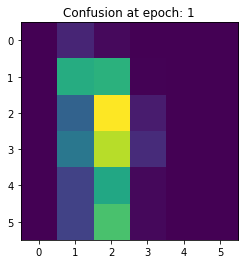

Epoch  1  is complete!
Complete in  547.7690989971161  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.42117703211100754
Validation Loss:  0.4198439422469983
Train Accuracy:  0.2686353211009174
Validation Accuracy:  0.27033218785796104
Confusion matrix:
[[  0  15   0   4   0   0]
 [  0 112   0  74   0   0]
 [  0  76   0 128   0   0]
 [  0  83   0 124   0   0]
 [  0  46   0  74   0   0]
 [  0  48   0  89   0   0]]


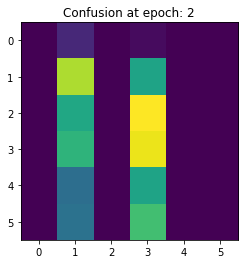

Epoch  2  is complete!
Complete in  555.3217170238495  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.419627140275066
Validation Loss:  0.4205049805516685
Train Accuracy:  0.2694954128440367
Validation Accuracy:  0.284077892325315
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 112  73   1   0   0]
 [  0  76 124   4   0   0]
 [  0  83 112  12   0   0]
 [  0  46  71   3   0   0]
 [  0  48  89   0   0   0]]


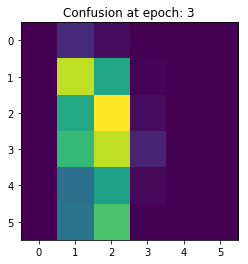

Epoch  3  is complete!
Complete in  553.1544127464294  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.4185439409266777
Validation Loss:  0.42027761859078927
Train Accuracy:  0.28411697247706424
Validation Accuracy:  0.2943871706758305
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 144  39   3   0   0]
 [  0 108  81  15   0   0]
 [  0  99  76  32   0   0]
 [  0  74  40   6   0   0]
 [  0  77  56   4   0   0]]


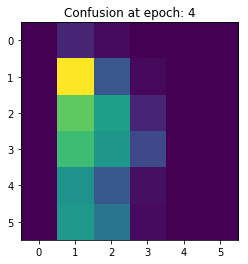

Epoch  4  is complete!
Complete in  613.8518011569977  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.41644370184758456
Validation Loss:  0.415696187699715
Train Accuracy:  0.3265481651376147
Validation Accuracy:  0.37915234822451316
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  91  95   0   0   0]
 [  0  46 157   1   0   0]
 [  0  26  98  83   0   0]
 [  0  29  90   1   0   0]
 [  0  29 108   0   0   0]]


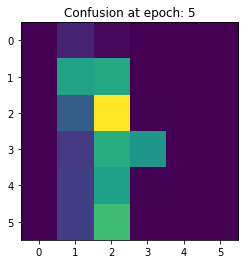

Epoch  5  is complete!
Complete in  634.5085201263428  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.4116418528880528
Validation Loss:  0.40909555910392364
Train Accuracy:  0.36840596330275227
Validation Accuracy:  0.3837342497136312
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  90  96   0   0   0]
 [  0  44 158   2   0   0]
 [  0  20 100  87   0   0]
 [  0  29  91   0   0   0]
 [  0  29 108   0   0   0]]


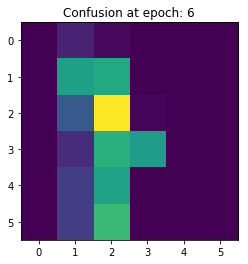

Epoch  6  is complete!
Complete in  499.30739641189575  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.40618292251657173
Validation Loss:  0.40304895305815075
Train Accuracy:  0.37786697247706424
Validation Accuracy:  0.40778923253150057
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 109  52   0  24   1]
 [  0  71 111   2  20   0]
 [  0  24  72  88  22   1]
 [  0  24  47   0  48   1]
 [  0  54  59   0  24   0]]


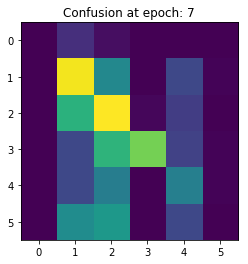

Epoch  7  is complete!
Complete in  537.7082192897797  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.40135147712604025
Validation Loss:  0.3958267221809748
Train Accuracy:  0.3973623853211009
Validation Accuracy:  0.4581901489117984
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  69  84   0   0  33]
 [  0  26 172   4   0   2]
 [  0   9 110  88   0   0]
 [  0  18  98   4   0   0]
 [  0  14  51   1   0  71]]


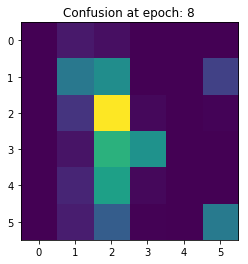

Epoch  8  is complete!
Complete in  538.620805978775  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3952060347371977
Validation Loss:  0.3899608659045338
Train Accuracy:  0.44724770642201833
Validation Accuracy:  0.45933562428407787
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  69  84   0   0  33]
 [  0  26 175   1   0   2]
 [  0   9 112  86   0   0]
 [  0  18 102   0   0   0]
 [  0  14  52   0   0  71]]


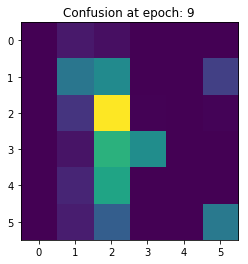

Epoch  9  is complete!
Complete in  487.2731297016144  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3898004061454387
Validation Loss:  0.3849206091422174
Train Accuracy:  0.4521215596330275
Validation Accuracy:  0.4616265750286369
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  85   0   0  33]
 [  0  25 174   3   0   2]
 [  0   8 109  90   0   0]
 [  0  18  99   3   0   0]
 [  0  11  55   0   0  71]]


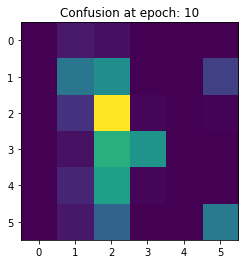

Epoch  10  is complete!
Complete in  484.27095317840576  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3853862960412424
Validation Loss:  0.3807079051518305
Train Accuracy:  0.45240825688073394
Validation Accuracy:  0.4639175257731959
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  69  67   0  17  33]
 [  0  25 156   1  20   2]
 [  0   8  93  88  18   0]
 [  0  18  81   0  21   0]
 [  0  11  31   0  24  71]]


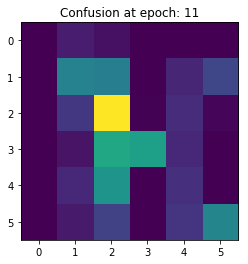

Epoch  11  is complete!
Complete in  542.2760372161865  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.38188079663970115
Validation Loss:  0.37709832420202666
Train Accuracy:  0.4481077981651376
Validation Accuracy:  0.47880870561282934
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  66  64   0  23  33]
 [  0  25 155   8  14   2]
 [  0   6  87  94  20   0]
 [  0  14  65   9  32   0]
 [  0  11  31   3  21  71]]


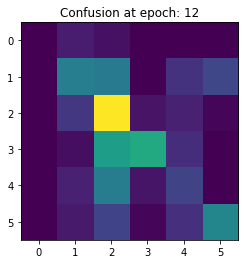

Epoch  12  is complete!
Complete in  608.0469176769257  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3782482864462575
Validation Loss:  0.37355888983983243
Train Accuracy:  0.4690366972477064
Validation Accuracy:  0.48911798396334477
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  66  64   0  23  33]
 [  0  25 156   0  21   2]
 [  0   6  90  86  25   0]
 [  0   5  66   1  48   0]
 [  0  11  31   0  24  71]]


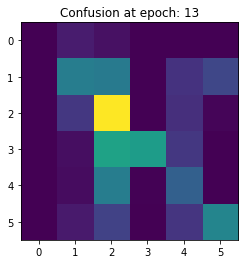

Epoch  13  is complete!
Complete in  618.2003231048584  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3749542933004011
Validation Loss:  0.3704397251352926
Train Accuracy:  0.4782110091743119
Validation Accuracy:  0.4925544100801833
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  65   0  21  33]
 [  0  25 156   0  21   2]
 [  0   5  91  85  26   0]
 [  0   2  67   0  51   0]
 [  0  11  31   0  24  71]]


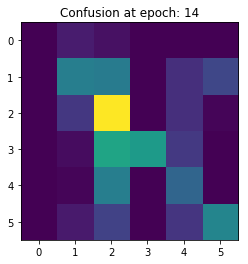

Epoch  14  is complete!
Complete in  609.3881525993347  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.37196596367694007
Validation Loss:  0.36738119255909085
Train Accuracy:  0.48480504587155965
Validation Accuracy:  0.4925544100801833
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  80   0   6  33]
 [  0  25 157   1  19   2]
 [  0   5  97  85  20   0]
 [  0   2  68   0  50   0]
 [  0  11  31   0  24  71]]


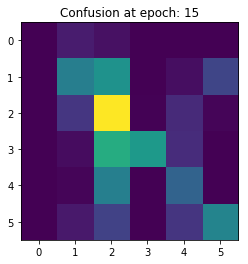

Epoch  15  is complete!
Complete in  669.9287104606628  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.36911869190003876
Validation Loss:  0.36465893330204563
Train Accuracy:  0.4974197247706422
Validation Accuracy:  0.5005727376861397
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  81   0   5  33]
 [  0  25 163   1  13   2]
 [  0   6 101  87  11   2]
 [  0   2  68   1  49   0]
 [  0  11  31   0  24  71]]


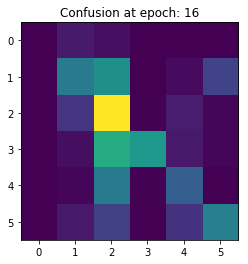

Epoch  16  is complete!
Complete in  555.699675321579  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3665442280397427
Validation Loss:  0.3619326799829873
Train Accuracy:  0.5
Validation Accuracy:  0.5085910652920962
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  77   3   6  33]
 [  0  25 142  19  12   6]
 [  0   5  75 109  16   2]
 [  0   2  65   4  46   3]
 [  0  11  26   5  15  80]]


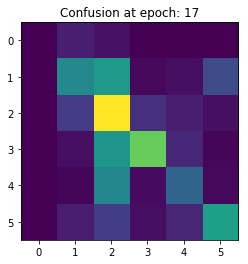

Epoch  17  is complete!
Complete in  491.5675575733185  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.36392980335418723
Validation Loss:  0.35999915468725824
Train Accuracy:  0.5103211009174312
Validation Accuracy:  0.5189003436426117
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  26 172   2   1   3]
 [  0   9 111  77   0  10]
 [  0   2  72   3  43   0]
 [  0  11  32   1   0  93]]


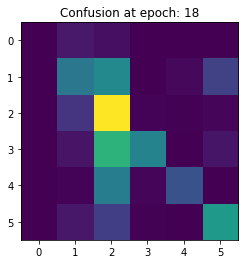

Epoch  18  is complete!
Complete in  484.71304845809937  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3615356090529084
Validation Loss:  0.3575009221865808
Train Accuracy:  0.5223623853211009
Validation Accuracy:  0.5257731958762887
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  73  80   2   4  27]
 [  0  26 156  18   1   3]
 [  0   9  93 103   0   2]
 [  0   2  66   7  43   2]
 [  0  20  31   2   0  84]]


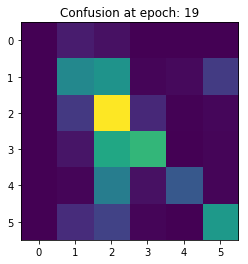

Epoch  19  is complete!
Complete in  575.9640667438507  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35932415509076315
Validation Loss:  0.3576049343478259
Train Accuracy:  0.5217889908256881
Validation Accuracy:  0.4742268041237113
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  66   0  20  33]
 [  0  25 152   3  22   2]
 [  0   5  85  73  44   0]
 [  0   2  64   3  51   0]
 [  0  11  31   0  24  71]]


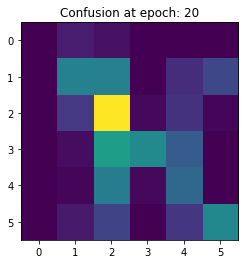

Epoch  20  is complete!
Complete in  617.2199976444244  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3573256289036808
Validation Loss:  0.3581212245720854
Train Accuracy:  0.5197821100917431
Validation Accuracy:  0.4845360824742268
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  70  81   0   2  33]
 [  0  28 164   9   1   2]
 [  0  10 101  96   0   0]
 [  1  19  72   6  22   0]
 [  0  11  33  22   0  71]]


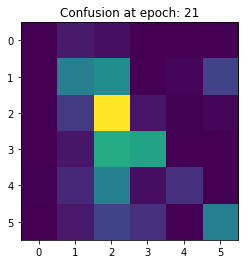

Epoch  21  is complete!
Complete in  624.4850788116455  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35534681959326414
Validation Loss:  0.356212301551429
Train Accuracy:  0.5263761467889908
Validation Accuracy:  0.5303550973654066
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  26 161  13   1   3]
 [  0   9  99  98   0   1]
 [  0   2  70   5  43   0]
 [  0  11  32   1   0  93]]


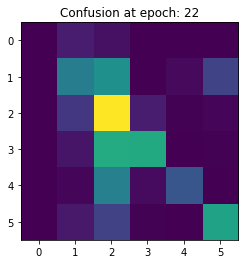

Epoch  22  is complete!
Complete in  651.9341180324554  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35346625230417306
Validation Loss:  0.3542043672908111
Train Accuracy:  0.5246559633027523
Validation Accuracy:  0.5303550973654066
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  80   2   4  33]
 [  0  25 154  21   1   3]
 [  0   8  92 106   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


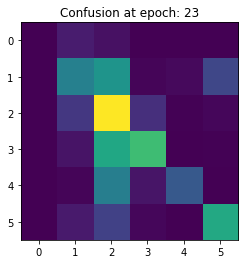

Epoch  23  is complete!
Complete in  623.7965261936188  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35194801643726686
Validation Loss:  0.35242555105423
Train Accuracy:  0.5177752293577982
Validation Accuracy:  0.5292096219931272
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  82   0   4  33]
 [  0  25 171   4   1   3]
 [  0   8 110  88   0   1]
 [  0   2  69   6  43   0]
 [  0  11  32   1   0  93]]


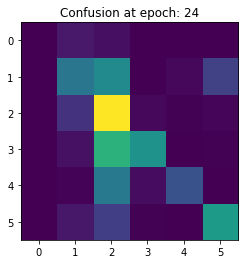

Epoch  24  is complete!
Complete in  605.9908411502838  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3503427765507106
Validation Loss:  0.3507308906694035
Train Accuracy:  0.5229357798165137
Validation Accuracy:  0.5315005727376861
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  82   0   4  33]
 [  0  25 163  12   1   3]
 [  0   8 100  98   0   1]
 [  0   2  66   9  43   0]
 [  0  11  32   1   0  93]]


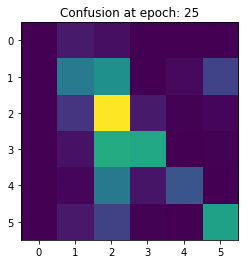

Epoch  25  is complete!
Complete in  738.0263938903809  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3488761616396573
Validation Loss:  0.3490758901091316
Train Accuracy:  0.5232224770642202
Validation Accuracy:  0.5360824742268041
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  76   4   4  35]
 [  0  25 146  25   1   7]
 [  0   5  81 117   0   4]
 [  0   2  65   4  43   6]
 [  0  11  26   5   0  95]]


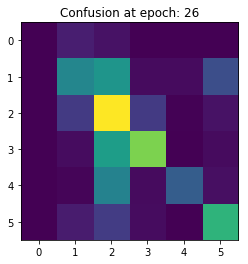

Epoch  26  is complete!
Complete in  570.0928032398224  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.34757243421531325
Validation Loss:  0.3476811133030372
Train Accuracy:  0.5275229357798165
Validation Accuracy:  0.5315005727376861
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  26 163  11   1   3]
 [  0   9 100  97   0   1]
 [  0   2  68   7  43   0]
 [  0  11  32   1   0  93]]


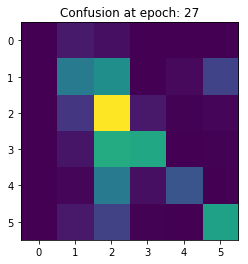

Epoch  27  is complete!
Complete in  562.7506020069122  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3462233055099366
Validation Loss:  0.34630872431536064
Train Accuracy:  0.5272362385321101
Validation Accuracy:  0.5326460481099656
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  79   3   4  33]
 [  0  25 152  23   1   3]
 [  0   8  85 110   0   4]
 [  0   2  69   6  43   0]
 [  0  11  26   7   0  93]]


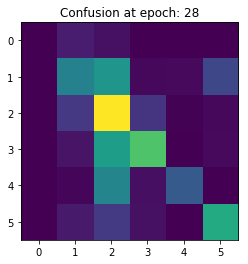

Epoch  28  is complete!
Complete in  585.8817799091339  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3450580983045529
Validation Loss:  0.3465347140343926
Train Accuracy:  0.523795871559633
Validation Accuracy:  0.49942726231386025
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  78   3   4  33]
 [  0  26 154  21   1   2]
 [  0   9 104  94   0   0]
 [  0   2  70   5  43   0]
 [  0  11  27  22   0  77]]


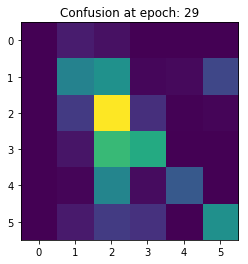

Epoch  29  is complete!
Complete in  608.065993309021  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3442555616198662
Validation Loss:  0.3454473337100747
Train Accuracy:  0.5094610091743119
Validation Accuracy:  0.5315005727376861
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  26 173   1   1   3]
 [  0   9 110  87   0   1]
 [  0   2  73   2  43   0]
 [  0  11  33   0   0  93]]


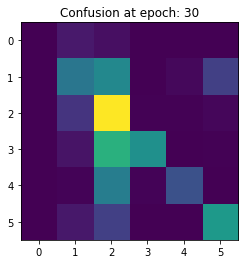

Epoch  30  is complete!
Complete in  609.6246535778046  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3432272488403881
Validation Loss:  0.3444093468071507
Train Accuracy:  0.5192087155963303
Validation Accuracy:  0.5303550973654066
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  27 173   0   1   3]
 [  0   9 111  86   0   1]
 [  0   2  75   0  43   0]
 [  0  11  33   0   0  93]]


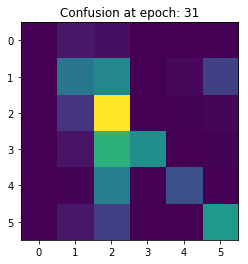

Epoch  31  is complete!
Complete in  643.7205173969269  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3421793109219489
Validation Loss:  0.3432512380976881
Train Accuracy:  0.5246559633027523
Validation Accuracy:  0.5349369988545246
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  81   0   4  33]
 [  0  25 170   5   1   3]
 [  0   8 105  93   0   1]
 [  0   2  72   3  43   0]
 [  0  11  33   0   0  93]]


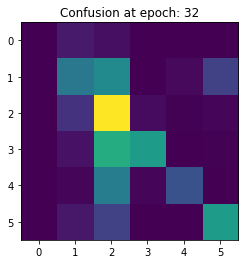

Epoch  32  is complete!
Complete in  596.6816246509552  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.341259661310968
Validation Loss:  0.34215643876796953
Train Accuracy:  0.5252293577981652
Validation Accuracy:  0.5292096219931272
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  82   0   4  33]
 [  0  25 161  14   1   3]
 [  0   6 100  98   0   3]
 [  0   2  70   5  43   0]
 [  0  11  32   1   0  93]]


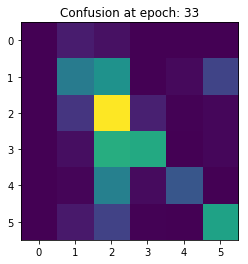

Epoch  33  is complete!
Complete in  626.4264848232269  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3404131937034183
Validation Loss:  0.3422454835661567
Train Accuracy:  0.5226490825688074
Validation Accuracy:  0.5085910652920962
Confusion matrix:
[[  0  12   3   4   0   0]
 [  0  68  61  20   4  33]
 [  0  26  80  94   1   3]
 [  0   9  37 160   0   1]
 [  0   2  43  32  43   0]
 [  0  11  13  20   0  93]]


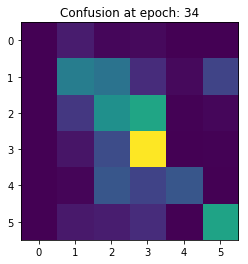

Epoch  34  is complete!
Complete in  620.8120329380035  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33965122881283033
Validation Loss:  0.34199996599150706
Train Accuracy:  0.5229357798165137
Validation Accuracy:  0.49140893470790376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  80   1   4  33]
 [  0  25 163  13   1   2]
 [  0   6 103  98   0   0]
 [  0   2  67   8  29  14]
 [  0  11  34  21   0  71]]


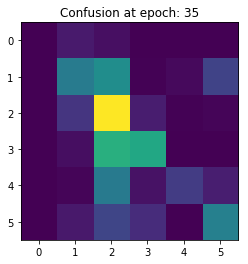

Epoch  35  is complete!
Complete in  602.5238366127014  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33887440596976615
Validation Loss:  0.3411183813946468
Train Accuracy:  0.5263761467889908
Validation Accuracy:  0.5337915234822451
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  82   0   4  33]
 [  0  25 165  10   1   3]
 [  0   6 102  98   0   1]
 [  0   2  67   8  43   0]
 [  0  11  31   2   0  93]]


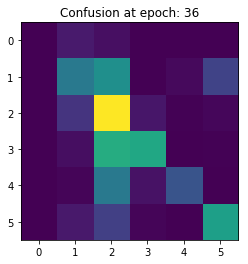

Epoch  36  is complete!
Complete in  580.5317296981812  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3381822665947383
Validation Loss:  0.3402826057622123
Train Accuracy:  0.5263761467889908
Validation Accuracy:  0.5337915234822451
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  78   3   4  34]
 [  0  25 138  33   1   7]
 [  0   5  73 124   0   5]
 [  0   2  64   5  43   6]
 [  0  11  25   7   0  94]]


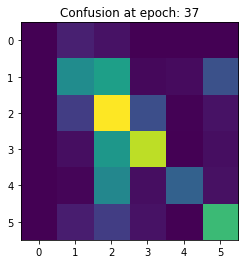

Epoch  37  is complete!
Complete in  558.8837602138519  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3374154739779579
Validation Loss:  0.33950115250689017
Train Accuracy:  0.5298165137614679
Validation Accuracy:  0.5280641466208477
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  79   2   4  33]
 [  0  26 156  18   1   3]
 [  0   9  96 101   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


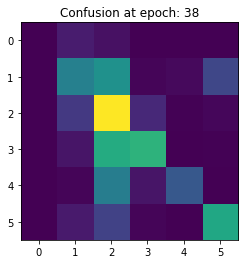

Epoch  38  is complete!
Complete in  494.2991507053375  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3367191719035507
Validation Loss:  0.33871561840775655
Train Accuracy:  0.5255160550458715
Validation Accuracy:  0.5349369988545246
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  69  79   1   4  33]
 [  0  25 158  17   1   3]
 [  0   8  94 104   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


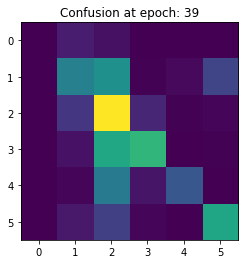

Epoch  39  is complete!
Complete in  492.78912353515625  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3360192400881361
Validation Loss:  0.3379217161649335
Train Accuracy:  0.5303899082568807
Validation Accuracy:  0.5326460481099656
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  68  78   3   4  33]
 [  0  25 152  23   1   3]
 [  0   6  91 109   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


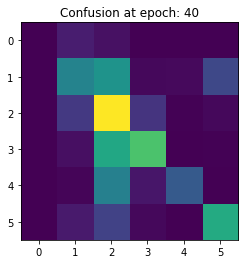

Epoch  40  is complete!
Complete in  494.83009672164917  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3352632473619495
Validation Loss:  0.33710795548448746
Train Accuracy:  0.5355504587155964
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 153  22   1   3]
 [  0   8  89 109   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


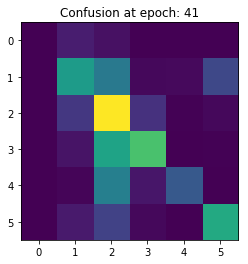

Epoch  41  is complete!
Complete in  493.9553303718567  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33464300670842934
Validation Loss:  0.33621868470713645
Train Accuracy:  0.5358371559633027
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   0   4  34]
 [  0  25 166   5   2   6]
 [  0   5 104  93   1   4]
 [  0   2  68   1  43   6]
 [  0  11  32   0   0  94]]


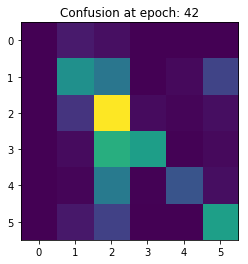

Epoch  42  is complete!
Complete in  493.58261036872864  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33393989325227724
Validation Loss:  0.335389561631205
Train Accuracy:  0.536697247706422
Validation Accuracy:  0.5589919816723941
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  61   4   4  33]
 [  0  25 151  24   1   3]
 [  0   6  83 117   0   1]
 [  0   2  66   9  43   0]
 [  0  11  26   7   0  93]]


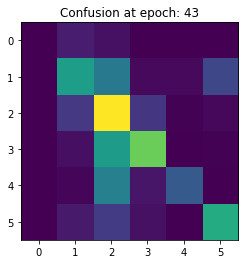

Epoch  43  is complete!
Complete in  495.5534772872925  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.333249323887987
Validation Loss:  0.33457784025312987
Train Accuracy:  0.5352637614678899
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 129  46   1   3]
 [  0   6  66 134   0   1]
 [  0   2  60  15  43   0]
 [  0  11  25   8   0  93]]


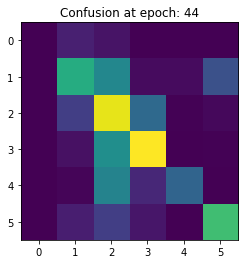

Epoch  44  is complete!
Complete in  497.7678737640381  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33253368706464215
Validation Loss:  0.3337669519307445
Train Accuracy:  0.5401376146788991
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  63   3   4  33]
 [  0  25 149  26   1   3]
 [  0   6  84 116   0   1]
 [  0   2  66   9  43   0]
 [  0  11  26   7   0  93]]


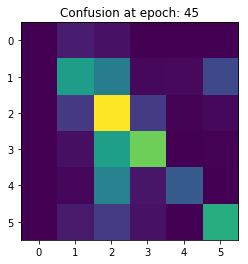

Epoch  45  is complete!
Complete in  542.7220094203949  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3321479344964987
Validation Loss:  0.3339900567622737
Train Accuracy:  0.5349770642201835
Validation Accuracy:  0.49026345933562426
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  26 174   1   1   2]
 [  0   9 123  37   0  38]
 [  0   2  75   0  43   0]
 [  0  11  33   3   0  90]]


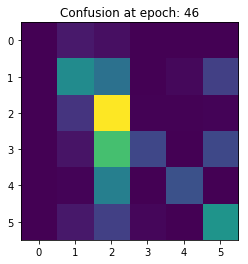

Epoch  46  is complete!
Complete in  585.9806642532349  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33158072112647763
Validation Loss:  0.3332448949302866
Train Accuracy:  0.5424311926605505
Validation Accuracy:  0.5475372279495991
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  25 159  16   1   3]
 [  0   6 101  99   0   1]
 [  0   2  69   6  43   0]
 [  0  11  31   2   0  93]]


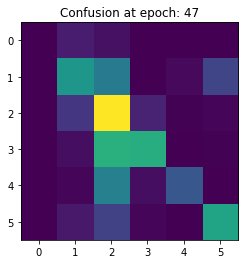

Epoch  47  is complete!
Complete in  575.9568214416504  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33094298316497694
Validation Loss:  0.3324891888817728
Train Accuracy:  0.544151376146789
Validation Accuracy:  0.5509736540664376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  64   2   4  33]
 [  0  25 150  25   1   3]
 [  0   5  89 112   0   1]
 [  0   2  67   8  43   0]
 [  0  11  30   3   0  93]]


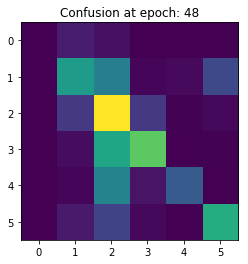

Epoch  48  is complete!
Complete in  572.0854916572571  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3303203536627348
Validation Loss:  0.33273535844137975
Train Accuracy:  0.5415711009174312
Validation Accuracy:  0.5418098510882016
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   2   4  35]
 [  0  25 144  20   1  14]
 [  0   5  79 108   0  15]
 [  0   2  64   5  43   6]
 [  0  11  30   1   0  95]]


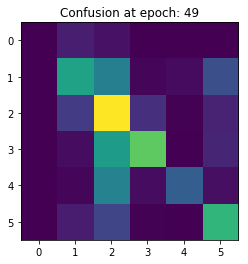

Epoch  49  is complete!
Complete in  570.0394427776337  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3297372390685767
Validation Loss:  0.3320458151176031
Train Accuracy:  0.5438646788990825
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  26 153  21   1   3]
 [  0   8  92 106   0   1]
 [  0   2  69   6  43   0]
 [  0  11  27   6   0  93]]


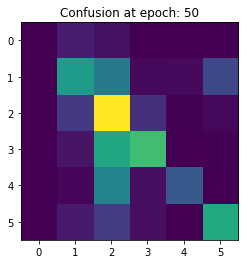

Epoch  50  is complete!
Complete in  589.4978969097137  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3292820890016742
Validation Loss:  0.3313925403291009
Train Accuracy:  0.5427178899082569
Validation Accuracy:  0.5509736540664376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  66   0   4  33]
 [  0  25 170   5   1   3]
 [  0   5 109  92   0   1]
 [  0   2  73   2  43   0]
 [  0  11  33   0   0  93]]


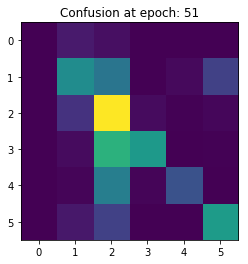

Epoch  51  is complete!
Complete in  514.9512481689453  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32873449808870897
Validation Loss:  0.3308282268565396
Train Accuracy:  0.5513188073394495
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  26 169   5   1   3]
 [  0   8 105  93   0   1]
 [  0   2  72   3  43   0]
 [  0  11  33   0   0  93]]


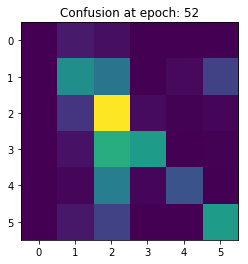

Epoch  52  is complete!
Complete in  492.48169469833374  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3282492214889956
Validation Loss:  0.3302418464218928
Train Accuracy:  0.5427178899082569
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  66   0   4  33]
 [  0  25 158  17   1   3]
 [  0   6  93 107   0   1]
 [  0   2  68   7  43   0]
 [  0  11  30   3   0  93]]


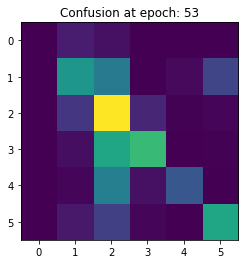

Epoch  53  is complete!
Complete in  494.6060166358948  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3277359098159303
Validation Loss:  0.3330710617087701
Train Accuracy:  0.5444380733944955
Validation Accuracy:  0.43184421534937
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  67  66   0   4  49]
 [  0  25 162  12   1   4]
 [  0   5 103  12   1  86]
 [  0   2  70   5  43   0]
 [  0  11  32   1   0  93]]


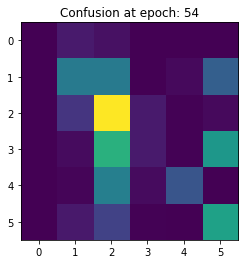

Epoch  54  is complete!
Complete in  522.3285660743713  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32730654424848693
Validation Loss:  0.3324221487436531
Train Accuracy:  0.5435779816513762
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 155  20   1   3]
 [  0   6  93 107   0   1]
 [  0   2  68   7  43   0]
 [  0  11  30   3   0  93]]


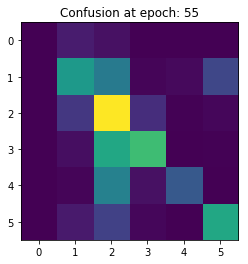

Epoch  55  is complete!
Complete in  557.0671000480652  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3268328601940818
Validation Loss:  0.3318592088485493
Train Accuracy:  0.5432912844036697
Validation Accuracy:  0.5509736540664376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 146  29   1   3]
 [  0   8  83 115   0   1]
 [  0   2  67   8  43   0]
 [  0  11  26   7   0  93]]


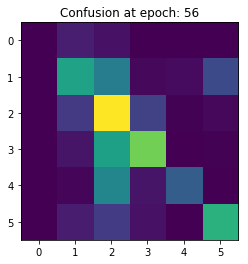

Epoch  56  is complete!
Complete in  628.5709223747253  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32647427870835083
Validation Loss:  0.3312813343431202
Train Accuracy:  0.5424311926605505
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 149  26   1   3]
 [  0   5  84 117   0   1]
 [  0   2  66   9  43   0]
 [  0  11  26   7   0  93]]


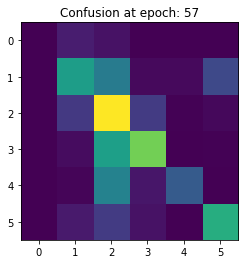

Epoch  57  is complete!
Complete in  544.8471217155457  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32606117574915555
Validation Loss:  0.33071757975062677
Train Accuracy:  0.5501720183486238
Validation Accuracy:  0.5498281786941581
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 159  16   1   3]
 [  0   5  99 102   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


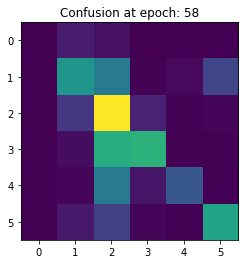

Epoch  58  is complete!
Complete in  646.883847951889  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32564750002472903
Validation Loss:  0.3301997875480084
Train Accuracy:  0.5455848623853211
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 155  20   1   3]
 [  0   6  91 109   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


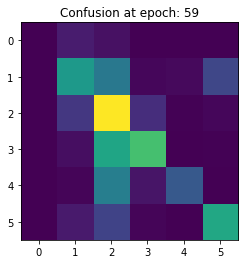

Epoch  59  is complete!
Complete in  692.6213948726654  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32521687642992814
Validation Loss:  0.32969354439148674
Train Accuracy:  0.5498853211009175
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 159  16   1   3]
 [  0   8  95 103   0   1]
 [  0   2  72   3  43   0]
 [  0  11  32   1   0  93]]


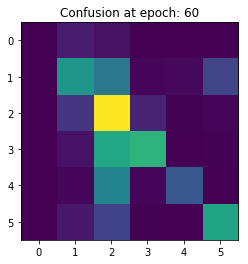

Epoch  60  is complete!
Complete in  577.9809737205505  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3247893956314259
Validation Loss:  0.32919400465322074
Train Accuracy:  0.544151376146789
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 151  24   1   3]
 [  0   6  89 111   0   1]
 [  0   2  68   7  43   0]
 [  0  11  26   7   0  93]]


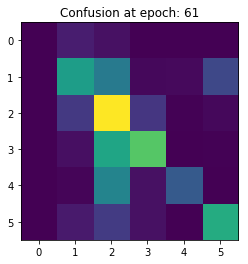

Epoch  61  is complete!
Complete in  649.6074471473694  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3244114757705281
Validation Loss:  0.3287425170801234
Train Accuracy:  0.5464449541284404
Validation Accuracy:  0.5498281786941581
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 154  21   1   3]
 [  0   8  92 106   0   1]
 [  0   2  69   6  43   0]
 [  0  11  27   6   0  93]]


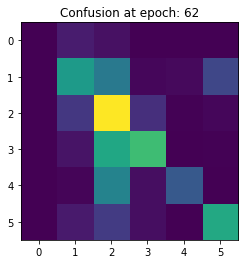

Epoch  62  is complete!
Complete in  582.5007543563843  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3240417698141851
Validation Loss:  0.32825715534948985
Train Accuracy:  0.5447247706422018
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 156  19   1   3]
 [  0   6  97 103   0   1]
 [  0   2  69   6  43   0]
 [  0  11  31   2   0  93]]


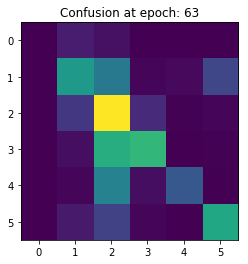

Epoch  63  is complete!
Complete in  709.9383141994476  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3236600067507237
Validation Loss:  0.3277691441607145
Train Accuracy:  0.5455848623853211
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 143  32   1   3]
 [  0   6  80 120   0   1]
 [  0   2  65  10  43   0]
 [  0  11  25   8   0  93]]


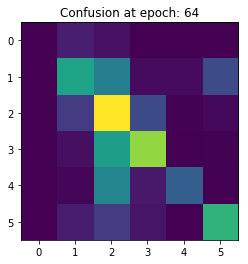

Epoch  64  is complete!
Complete in  650.7942779064178  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3236510871961611
Validation Loss:  0.3272959827408837
Train Accuracy:  0.53125
Validation Accuracy:  0.5521191294387171
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 150  25   1   3]
 [  0   6  87 113   0   1]
 [  0   2  66   9  43   0]
 [  0  11  26   7   0  93]]


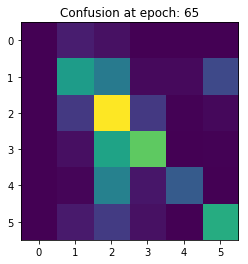

Epoch  65  is complete!
Complete in  637.1313788890839  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32328852993686313
Validation Loss:  0.32687969786097476
Train Accuracy:  0.5438646788990825
Validation Accuracy:  0.5498281786941581
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 159  16   1   3]
 [  0   6  98 102   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


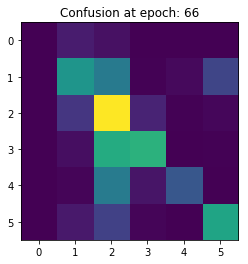

Epoch  66  is complete!
Complete in  574.0886871814728  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3229357111327684
Validation Loss:  0.3264382298162752
Train Accuracy:  0.5490252293577982
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  63   3   4  33]
 [  0  25 150  25   1   3]
 [  0   5  86 115   0   1]
 [  0   2  66   9  43   0]
 [  0  11  27   6   0  93]]


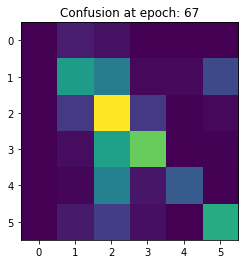

Epoch  67  is complete!
Complete in  530.8288588523865  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32261928111481086
Validation Loss:  0.3260021590622993
Train Accuracy:  0.5470183486238532
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  25 159  16   1   3]
 [  1   7  98 100   0   1]
 [  0   2  69   6  43   0]
 [  0  11  31   2   0  93]]


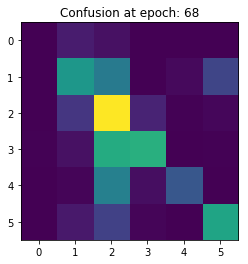

Epoch  68  is complete!
Complete in  516.6421737670898  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32227641586307504
Validation Loss:  0.3256014909950319
Train Accuracy:  0.5498853211009175
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  64   2   4  33]
 [  0  25 153  22   1   3]
 [  0   5  94 107   0   1]
 [  0   2  68   7  43   0]
 [  0  11  30   3   0  93]]


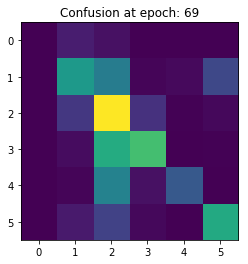

Epoch  69  is complete!
Complete in  638.2762801647186  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3219598771254685
Validation Loss:  0.3252298469076718
Train Accuracy:  0.5467316513761468
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 155  20   1   3]
 [  0   5  96 105   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


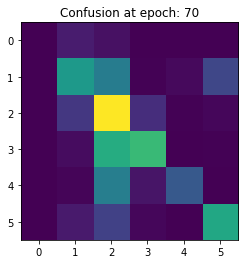

Epoch  70  is complete!
Complete in  719.1673009395599  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32160803199102017
Validation Loss:  0.32485935704083946
Train Accuracy:  0.5521788990825688
Validation Accuracy:  0.5475372279495991
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  25 159  16   1   3]
 [  0   6 101  99   0   1]
 [  0   2  69   6  43   0]
 [  0  11  31   2   0  93]]


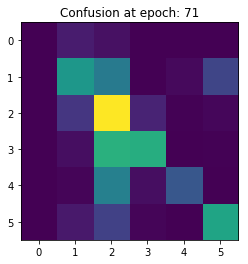

Epoch  71  is complete!
Complete in  707.7189385890961  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.321335884366046
Validation Loss:  0.3244908865329172
Train Accuracy:  0.549598623853211
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  61   4   4  33]
 [  0  25 152  23   1   3]
 [  0   6  88 112   0   1]
 [  0   2  68   7  43   0]
 [  0  11  27   6   0  93]]


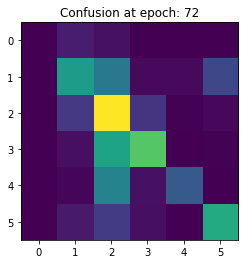

Epoch  72  is complete!
Complete in  690.9400429725647  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32108088475915547
Validation Loss:  0.3241475324977246
Train Accuracy:  0.544151376146789
Validation Accuracy:  0.5532646048109966
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  64   2   4  33]
 [  0  25 153  22   1   3]
 [  0   5  90 111   0   1]
 [  0   2  67   8  43   0]
 [  0  11  30   3   0  93]]


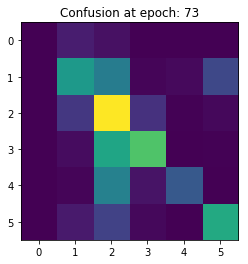

Epoch  73  is complete!
Complete in  726.8487195968628  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32078325437686855
Validation Loss:  0.3238456871498299
Train Accuracy:  0.5478784403669725
Validation Accuracy:  0.5463917525773195
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  98  51   0   4  33]
 [  0  42 149   9   1   3]
 [  0  19  93  94   0   1]
 [  0   8  63   6  43   0]
 [  0  12  31   1   0  93]]


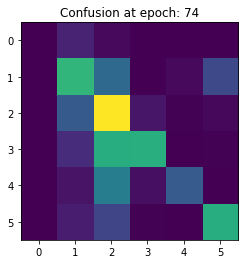

Epoch  74  is complete!
Complete in  704.1589045524597  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32055719855370846
Validation Loss:  0.32352393442102345
Train Accuracy:  0.5461582568807339
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 158  17   1   3]
 [  0   6  92 108   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


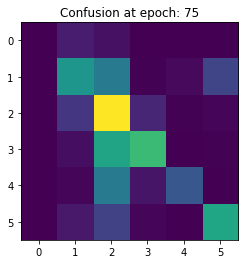

Epoch  75  is complete!
Complete in  595.3697373867035  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3204025747144974
Validation Loss:  0.3231925151657081
Train Accuracy:  0.5455848623853211
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 147  28   1   3]
 [  0   8  80 118   0   1]
 [  0   2  65  10  43   0]
 [  0  11  26   7   0  93]]


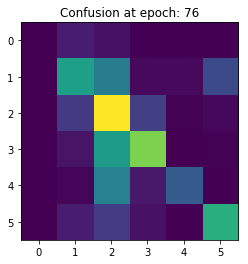

Epoch  76  is complete!
Complete in  669.680029630661  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32012595606086564
Validation Loss:  0.3228663944088326
Train Accuracy:  0.5447247706422018
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 159  16   1   3]
 [  0   6  94 106   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


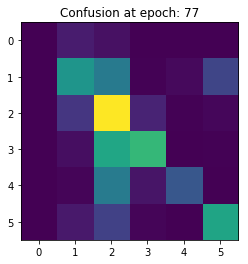

Epoch  77  is complete!
Complete in  636.0429329872131  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31995660074234894
Validation Loss:  0.3225612592964409
Train Accuracy:  0.5455848623853211
Validation Accuracy:  0.5418098510882016
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  93  64   2   4  23]
 [  0  27 151  23   2   1]
 [  0   6  88 111   1   1]
 [  0   2  67   8  43   0]
 [  0  29  30   3   0  75]]


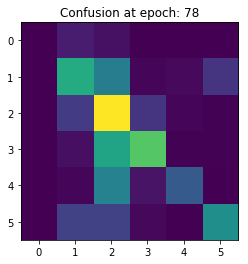

Epoch  78  is complete!
Complete in  547.2554998397827  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3197606630825933
Validation Loss:  0.3222672983927774
Train Accuracy:  0.5470183486238532
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 162  13   1   3]
 [  0   6  97 103   0   1]
 [  0   2  66   9  43   0]
 [  0  11  31   2   0  93]]


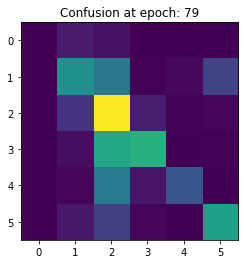

Epoch  79  is complete!
Complete in  549.399092912674  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.319522737953993
Validation Loss:  0.32199729959066514
Train Accuracy:  0.5501720183486238
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  64   1   4  33]
 [  0  25 155  20   1   3]
 [  0   8  94 104   0   1]
 [  0   2  67   8  43   0]
 [  0  11  31   2   0  93]]


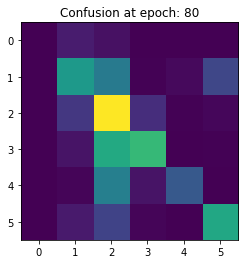

Epoch  80  is complete!
Complete in  613.3495151996613  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31930515626246725
Validation Loss:  0.32166027111798307
Train Accuracy:  0.5470183486238532
Validation Accuracy:  0.5567010309278351
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 148  27   1   3]
 [  0   6  81 119   0   1]
 [  0   2  65  10  43   0]
 [  0  11  26   7   0  93]]


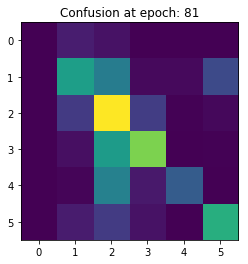

Epoch  81  is complete!
Complete in  529.5484702587128  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3190554807203923
Validation Loss:  0.3214123307658518
Train Accuracy:  0.5458715596330275
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  61   4   4  33]
 [  0  25 150  25   1   3]
 [  0   8  83 115   0   1]
 [  0   2  66   9  43   0]
 [  0  11  27   6   0  93]]


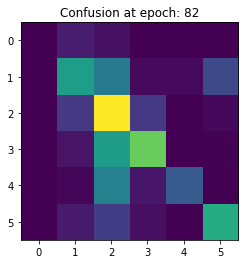

Epoch  82  is complete!
Complete in  580.8776981830597  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31895679043591185
Validation Loss:  0.3211464349746021
Train Accuracy:  0.5372706422018348
Validation Accuracy:  0.5532646048109966
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 151  24   1   3]
 [  0   6  88 112   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


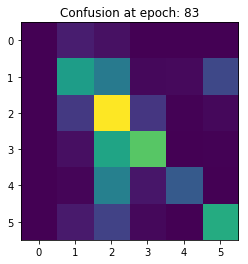

Epoch  83  is complete!
Complete in  727.4662988185883  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3187810293877112
Validation Loss:  0.3208888376991626
Train Accuracy:  0.5461582568807339
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 153  22   1   3]
 [  0   6  93 107   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


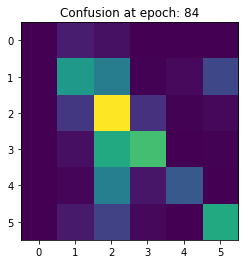

Epoch  84  is complete!
Complete in  587.1673843860626  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3186226725257496
Validation Loss:  0.32062736720868557
Train Accuracy:  0.5464449541284404
Validation Accuracy:  0.5509736540664376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  63   3   4  33]
 [  0  25 152  23   1   3]
 [  0   6  90 110   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


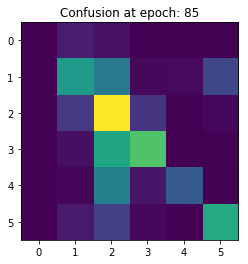

Epoch  85  is complete!
Complete in  573.7850081920624  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31839119442965924
Validation Loss:  0.32035715432631573
Train Accuracy:  0.5461582568807339
Validation Accuracy:  0.5532646048109966
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 152  23   1   3]
 [  0   5  90 111   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


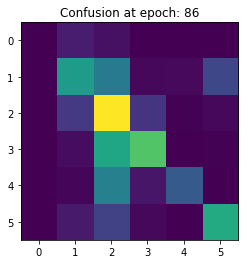

Epoch  86  is complete!
Complete in  602.1257257461548  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3182425381996392
Validation Loss:  0.32009333427434516
Train Accuracy:  0.5510321100917431
Validation Accuracy:  0.5509736540664376
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 154  21   1   3]
 [  0   5  94 107   0   1]
 [  0   2  68   7  43   0]
 [  0  11  31   2   0  93]]


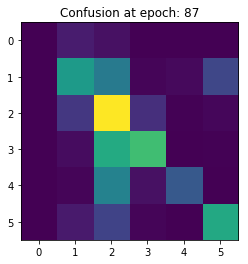

Epoch  87  is complete!
Complete in  24115.897564649582  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.318081622141434
Validation Loss:  0.31985277880948393
Train Accuracy:  0.5475917431192661
Validation Accuracy:  0.5498281786941581
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 158  17   1   3]
 [  0   8  96 102   0   1]
 [  0   2  70   5  43   0]
 [  0  11  31   2   0  93]]


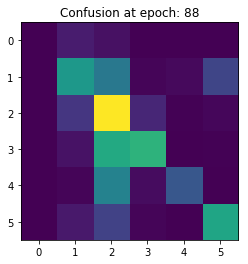

Epoch  88  is complete!
Complete in  642.0313899517059  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3180306645197138
Validation Loss:  0.31964008859011567
Train Accuracy:  0.5461582568807339
Validation Accuracy:  0.5498281786941581
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 152  23   1   3]
 [  0   8  90 108   0   1]
 [  0   2  69   6  43   0]
 [  0  11  27   6   0  93]]


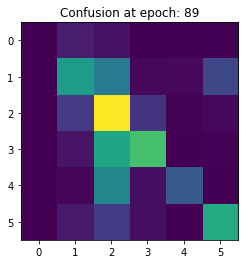

Epoch  89  is complete!
Complete in  647.2064514160156  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31788313880274405
Validation Loss:  0.3194404368488674
Train Accuracy:  0.5504587155963303
Validation Accuracy:  0.5475372279495991
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 153  22   1   3]
 [  0   8  91 108   0   0]
 [  0   2  69   6  43   0]
 [  0  11  27   9   0  90]]


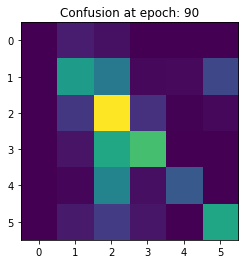

Epoch  90  is complete!
Complete in  643.6296246051788  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31773740400459666
Validation Loss:  0.3191939139500545
Train Accuracy:  0.5447247706422018
Validation Accuracy:  0.5567010309278351
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 146  29   1   3]
 [  0   5  80 121   0   1]
 [  0   2  66   9  43   0]
 [  0  11  26   7   0  93]]


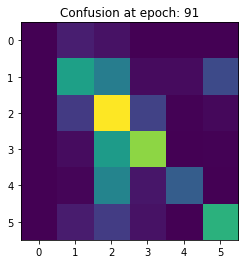

Epoch  91  is complete!
Complete in  616.4894847869873  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31764422761726946
Validation Loss:  0.3189560163125555
Train Accuracy:  0.5501720183486238
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  62   4   4  33]
 [  0  25 138  37   1   3]
 [  0   5  74 127   0   1]
 [  0   2  64  11  43   0]
 [  0  11  25   8   0  93]]


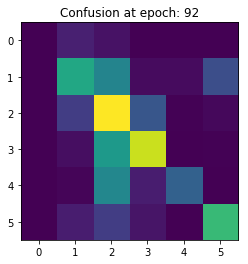

Epoch  92  is complete!
Complete in  613.6364340782166  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31745207458973634
Validation Loss:  0.3187502777271512
Train Accuracy:  0.5470183486238532
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  63   2   4  33]
 [  0  25 154  21   1   3]
 [  0   8  93 105   0   1]
 [  0   2  68   7  43   0]
 [  0  11  31   2   0  93]]


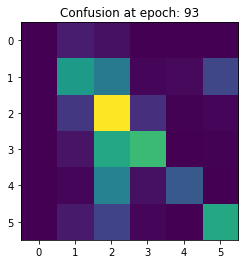

Epoch  93  is complete!
Complete in  617.8563466072083  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3172883991073866
Validation Loss:  0.31857548002674757
Train Accuracy:  0.5487385321100917
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  25 160  15   1   3]
 [  0   8  99  99   0   1]
 [  0   2  69   6  43   0]
 [  0  11  31   2   0  93]]


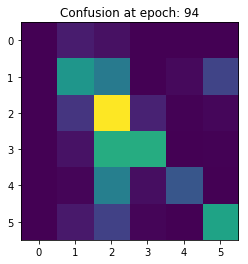

Epoch  94  is complete!
Complete in  668.9507055282593  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3170948959471998
Validation Loss:  0.31839015072667104
Train Accuracy:  0.5530389908256881
Validation Accuracy:  0.5463917525773195
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  65   0   4  33]
 [  0  25 158  17   1   3]
 [  0   8  99  99   0   1]
 [  0   2  68   7  43   0]
 [  0  11  31   2   0  93]]


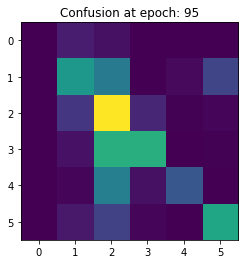

Epoch  95  is complete!
Complete in  683.5045680999756  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31700015599916703
Validation Loss:  0.31816280479688913
Train Accuracy:  0.5458715596330275
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  63   3   4  33]
 [  0  25 152  23   1   3]
 [  0   6  86 114   0   1]
 [  0   2  66   9  43   0]
 [  0  11  30   3   0  93]]


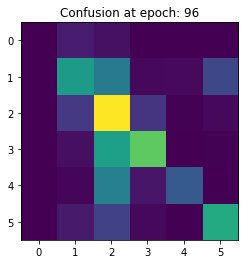

Epoch  96  is complete!
Complete in  791.7043960094452  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3168428211340687
Validation Loss:  0.31796024891066926
Train Accuracy:  0.5527522935779816
Validation Accuracy:  0.5532646048109966
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  62   3   4  33]
 [  0  25 154  21   1   3]
 [  0   8  89 109   0   1]
 [  0   2  68   7  43   0]
 [  0  11  31   2   0  93]]


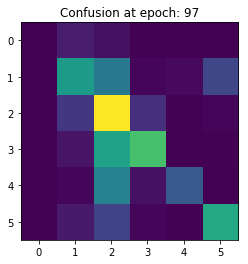

Epoch  97  is complete!
Complete in  701.7628540992737  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31672076603225835
Validation Loss:  0.31773045992868054
Train Accuracy:  0.5498853211009175
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  61   4   4  33]
 [  0  25 146  29   1   3]
 [  0   6  81 119   0   1]
 [  0   2  65  10  43   0]
 [  0  11  26   7   0  93]]


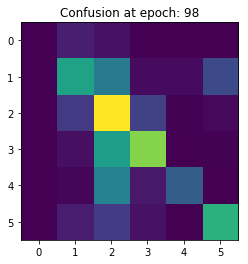

Epoch  98  is complete!
Complete in  605.4915328025818  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31653829819574475
Validation Loss:  0.3175418383257048
Train Accuracy:  0.5561926605504587
Validation Accuracy:  0.5544100801832761
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  83  65   1   4  33]
 [  0  25 153  22   1   3]
 [  0   5  89 112   0   1]
 [  0   2  65  10  43   0]
 [  0  11  30   3   0  93]]


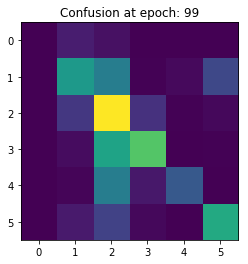

Epoch  99  is complete!
Complete in  500.60235834121704  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3165084885001576
Validation Loss:  0.3173891591474755
Train Accuracy:  0.5344036697247706
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0  84  64   1   4  33]
 [  0  25 166  10   1   2]
 [  0   6 100 101   0   0]
 [  0   2  67   8  43   0]
 [  0  11  32   9   0  85]]


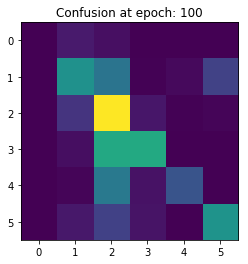

FileNotFoundError: [Errno 2] No such file or directory: 'ques_lstm/postprocess1_300n_3l_100'

In [178]:
# loading initialized weights from the model in option 1 to compare resulting training results 
#init_mod1 = loading(mod1, 'init_300n_3l')

# training and validating the model on the post processed embeddings
#tr_mod1, res1 = train_valid(init_mod1, tr1, va1, 100, 5, 'postprocess1_300n_3l_')

In [184]:
# resaving the trained model due to an error
#saving(init_mod1, 'postprocess1_300n_3l_100')

C:\Users\sunny\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type gensim_lstm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [185]:
## loading the most recently trained model

# setting a sample structure before loading a trained model
mod0 = set_model(300, 3, 0.7)

# directly load the trained lstm model
trained_lstm = loading(mod0, 'postprocess1_300n_3l_100')

Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 300, num_layers=3, dropout=0.7)
  (dense): Linear(in_features=600, out_features=6, bias=True)
  (sigm): Sigmoid()
)


In [190]:
def test_model(model, test):
    '''
    model: the trained model that will then be tested
    test: the testing dataset (test[0] is input test[1] is output)
    '''
    
    # loss function
    loss_fn = torch.nn.BCELoss()
    
    # setting model to train mode
    model.eval()
    
    predict_class, actual_class = [], []
    test_losses, all_class = [], []
    
    # iterating through the training data
    for vec in range(len(test[0])):

        # initializing the hidden layer
        hid = model.init_hidden()

        # setting up the input and output
        inp = text_tensor(test[0].iloc[vec], post_process1)
        out = torch.tensor(test[1].iloc[vec], dtype=torch.float).reshape(1, -1)

        pred = model(inp, hid)

        # calculating the loss
        loss = loss_fn(pred, out)
        test_losses.append(loss.item())

        actual_class.append(torch.argmax(out))
        predict_class.append(torch.argmax(pred).detach())
        all_class.append(pred.detach())
        
        op = ""
        if actual_class[-1] == predict_class[-1]:
            op = 'Y'
        else:
            op = 'N'
            
        print(vec, " : ", "actual - ", test[1].columns[actual_class[-1].item()], 
              " predict - ", test[1].columns[predict_class[-1].item()], " grade: ", op)
    
    accuracy = sk.metrics.accuracy_score(actual_class, predict_class)
    confusion = sk.metrics.confusion_matrix(actual_class, predict_class)
    
    print("Accuracy: ", accuracy)
    print("Confusion matrix:")
    print(confusion)

    title = "Confusion visualization"
    plt.title(title)
    plt.imshow(confusion)
    plt.show()
    
    return all_class

C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
1  :  actual -  ('ENTY',)  predict -  ('DESC',)  grade:  N
2  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
3  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
4  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
5  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N


C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


6  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
7  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
8  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
9  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
10  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
11  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
12  :  actual -  ('NUM',)  predict -  ('ENTY',)  grade:  N
13  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
14  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
15  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
16  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
17  :  actual -  ('NUM',)  predict -  ('ENTY',)  grade:  N
18  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
19  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
20  :  actual -  ('NUM',)  predict -  ('HUM',)  grade:  N
21  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
22  :  actual -  ('ENTY',)  predict -  ('DESC',)  grade:  N

152  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
153  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
154  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
155  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
156  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
157  :  actual -  ('ENTY',)  predict -  ('DESC',)  grade:  N
158  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
159  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
160  :  actual -  ('ABBR',)  predict -  ('HUM',)  grade:  N
161  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
162  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
163  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
164  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
165  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
166  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
167  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
168  :  actual -  ('HUM',)  predict 

292  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
293  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
294  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
295  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
296  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
297  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
298  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
299  :  actual -  ('NUM',)  predict -  ('ENTY',)  grade:  N
300  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
301  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
302  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
303  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
304  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
305  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
306  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
307  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
308  :  actual -  ('HUM',)  predict - 

431  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
432  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
433  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
434  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
435  :  actual -  ('NUM',)  predict -  ('ENTY',)  grade:  N
436  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
437  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
438  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
439  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
440  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
441  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
442  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
443  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
444  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
445  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
446  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
447  :  actual -  ('NUM',)  predict 

579  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
580  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
581  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
582  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
583  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
584  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
585  :  actual -  ('NUM',)  predict -  ('ENTY',)  grade:  N
586  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
587  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
588  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
589  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
590  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
591  :  actual -  ('LOC',)  predict -  ('DESC',)  grade:  N
592  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
593  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
594  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
595  :  actual -  ('NUM',)  predict -  ('NUM

724  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
725  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
726  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
727  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
728  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
729  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
730  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
731  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
732  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
733  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
734  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
735  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
736  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
737  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
738  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
739  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
740  :  actual -  ('DESC',)  predict

861  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
862  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
863  :  actual -  ('ABBR',)  predict -  ('ENTY',)  grade:  N
864  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
865  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
866  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
867  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
868  :  actual -  ('DESC',)  predict -  ('LOC',)  grade:  N
869  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
870  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
871  :  actual -  ('ABBR',)  predict -  ('ENTY',)  grade:  N
872  :  actual -  ('LOC',)  predict -  ('LOC',)  grade:  Y
873  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
874  :  actual -  ('DESC',)  predict -  ('NUM',)  grade:  N
875  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
876  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
877  :  actual -  ('DESC',)  predict - 

1002  :  actual -  ('ENTY',)  predict -  ('HUM',)  grade:  N
1003  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
1004  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
1005  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
1006  :  actual -  ('HUM',)  predict -  ('DESC',)  grade:  N
1007  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
1008  :  actual -  ('LOC',)  predict -  ('ENTY',)  grade:  N
1009  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
1010  :  actual -  ('HUM',)  predict -  ('HUM',)  grade:  Y
1011  :  actual -  ('NUM',)  predict -  ('NUM',)  grade:  Y
1012  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
1013  :  actual -  ('DESC',)  predict -  ('ENTY',)  grade:  N
1014  :  actual -  ('DESC',)  predict -  ('DESC',)  grade:  Y
1015  :  actual -  ('HUM',)  predict -  ('ENTY',)  grade:  N
1016  :  actual -  ('ABBR',)  predict -  ('DESC',)  grade:  N
1017  :  actual -  ('ENTY',)  predict -  ('ENTY',)  grade:  Y
1018  :  actual -  

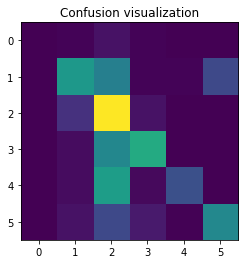

In [191]:
mod1_test_results = test_model(trained_lstm, te1)